In [ ]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import preprocessamento 
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
import plotly.express as px
from scipy.stats import mannwhitneyu, ttest_ind
from scipy.stats import levene

### Selecione o indicador a ser explorado e coloque-o entre os parênteses de "preparo()" na próxima célula.

<div align="center">

| **Indicador** | **Descrição**                                                                      |
|---------------|------------------------------------------------------------------------------------|
| DEC           | Duração Equivalente de Interrupção por Unidade Consumidora - 3 Min.              |
| DECINC        | DEC de interrupção de origem interna à Distribuidora, não programada e ocorrida em Dia Crítico |
| DECIND        | DEC de interrupção de origem interna, não programada e não expurgável                       |
| DECINE        | DEC de interrupção de origem interna, não programada e não expurgável e ocorrida em Situação de Emergência fora de Dia Crítico |
| DECINO        | DEC de interrupção de origem interna não programada e não expurgável, Racionamento e ONS, fora de Dia Crítico  |
| DECIP         | DEC de interrupção de origem interna à Distribuidora e programada                |
| DECIPC        | DEC de interrupção de origem interna à Distribuidora, programada e ocorrida em Dia Crítico           |
| DECXN         | DEC de interrupção de origem externa à Distribuidora e não programada            |
| DECXNC        | DEC interrupção de origem externa à Distribuidora, não programada e ocorrida em Dia Crítico       |
| DECXP         | DEC de interrupção de origem externa à Distribuidora e programada                |
| DECXPC        | DEC interrupção de origem externa à Distribuidora, programada e ocorrida em Dia Crítico             |
| FEC           | Freqüência Equivalente de Interrupção por Unidade Consumidora - 3 Min.             |
| FECINC        | FEC de interrupção de origem interna à Distribuidora não programada e ocorrida em Dia Crítico |
| FECIND        | FEC de interrupção de origem interna, não programada e não expurgável                       |
| FECINE        | FEC interrupção de origem interna, não programada e não expurgável e ocorrida em Situação de Emergência, fora de Dia Crítico     |
| FECINO        | FEC interrupção de origem interna não programada e não expurgável Racionamento e ONS, fora de Dia Crítico  |
| FECIP         | FEC de interrupção de origem interna à Distribuidora e programada                |
| FECIPC        | FEC de interrupção de origem interna à Distribuidora, programada e ocorrida em Dia Crítico           |
| FECXN         | FEC de interrupção de origem externa à Distribuidora e não programada            |
| FECXNC        | FEC interrupção de origem externa ao sist distr, não programada e ocorrida em Dia Crítico       |
| FECXP         | FEC de interrupção de origem externa à Distribuidora e programada                |
| FECXPC        | FEC interrupção de origem externa ao sist distr, programada e ocorrida em Dia Crítico             |
| NumCon        | Número de Consumidores do Conjunto no Período                                      |
</div>

In [2]:
dec_ext_np = preprocessamento.preparo('DECXN') 
dec_ext_np_critico = preprocessamento.preparo('DECXNC') 
num_cons = preprocessamento.preparo('NumCon') 

In [ ]:
# Trazendo número de consumidores para dentro do dataset de DECXN
dec_ext_np = dec_ext_np.merge(num_cons[['Data', 'DscConjUndConsumidoras','VlrIndiceEnviado']], on=['Data', 'DscConjUndConsumidoras'])
dec_ext_np = dec_ext_np.rename(columns={
    'VlrIndiceEnviado_x': 'DEC', 
    'VlrIndiceEnviado_y': 'Consumidores'
})


In [ ]:
# Dada à presumível variação no número de clientes ao longo do tempo, criaremos uma coluna de DECXN ponderado para caso seja necessário
total_consumidores_por_mes = dec_ext_np.groupby('Data')['Consumidores'].transform('sum')
dec_ext_np['DEC Ponderado'] = (dec_ext_np['DEC'] * dec_ext_np['Consumidores']) / total_consumidores_por_mes

In [ ]:
# Primeira exploração visual dos dados
fig = px.line(dec_ext_np, x='Data', y='DEC', title='DEC de Origem Externa e Não Programada')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Vê-se que na ENEL parece haver menos picos de DEC, mas uma preponderância de picos mais longos que os da Eletropaulo. Ainda assim, há de se notar a abundância de valores zerados (o que é compreensível, dado que o indicador se trata de momentos externos e imprevistos). E se removermo-los?

In [18]:
# Repetindo o gráfico, mas eliminando zeros
df_com_interrupcao = dec_ext_np[dec_ext_np['DEC'] > 0.01].sort_values('Data') # Pequena tolerância para ruídos
fig = px.line(df_com_interrupcao, x='Data', y='DEC', title='DEC de Origem Externa e Não Programada')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

A impressão permanece, mas sem nada que chame a atenção. Talvez devamos recorrer a boxplots para explorar melhor a distribuição dos dados.

C:\Users\julia\AppData\Local\Temp\ipykernel_18072\4078580597.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




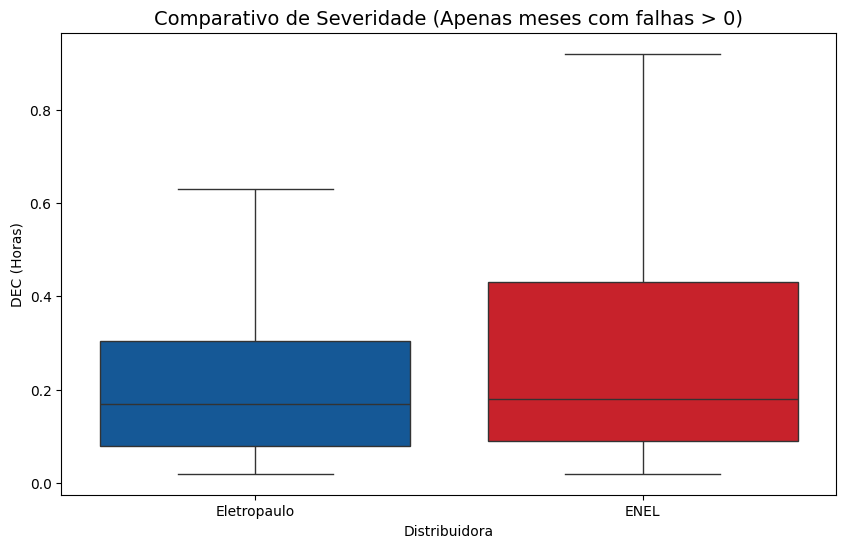

                 count      mean       std  min  25%  50%  75%  90%  95%   max
Distribuidora                                                                 
ENEL           12594.0  0.006776  0.078836  0.0  0.0  0.0  0.0  0.0  0.0  2.64
Eletropaulo    12920.0  0.004902  0.048482  0.0  0.0  0.0  0.0  0.0  0.0  1.73


In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_com_interrupcao, x='Distribuidora', y='DEC', showfliers=False, palette=['#0059ab', '#e30613'])
plt.title('Comparativo de Severidade (Apenas meses com falhas > 0)', fontsize=14)
plt.ylabel('DEC (Horas)')
plt.show()


A ENEL começa a despontar com maior volume de dados acima dos +-0.3 de DEC. Vejamos os números brutos.

In [20]:
print(df_com_interrupcao.groupby('Distribuidora')['DEC'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]))

               count      mean       std   min   25%   50%    75%    90%  \
Distribuidora                                                              
ENEL           243.0  0.350206  0.450159  0.02  0.09  0.18  0.430  0.916   
Eletropaulo    259.0  0.243166  0.243990  0.02  0.08  0.17  0.305  0.580   

                 95%   max  
Distribuidora               
ENEL           1.288  2.64  
Eletropaulo    0.750  1.73  


Há poucos pontos de dados para a Eletropaulo a mais do que a ENEL, então deixaremos a pequena diferença de lado. A média chama a atenção (0.35 da ENEL vs 0.24 para a Eletropaulo), bem como o desvio padrão maior da primeira, que mostra maior variabilidade nos resultados da empresa italiana. Até a mediana, os números são similares, mas a partir do 3º percentil a ENEL mostra números consideravelmente maiores, o que distorce seus dados para a esquerda. **O problema da ENEL parece estar nos picos, os outliers, e não na rotina.**

In [35]:
# Separando os grupos
dec_enel = dec_ext_np[dec_ext_np['Distribuidora'] == 'ENEL']['DEC']
dec_eletro = dec_ext_np[dec_ext_np['Distribuidora'] == 'Eletropaulo']['DEC']

# Variação Percentual da Média
aumento_pct = (dec_enel.mean() - dec_eletro.mean()) / dec_eletro.mean()
print(f"Aumento percentual da Média do DEC: {aumento_pct:.1%}")

Aumento percentual da Média do DEC: 38.2%


Será que já podemos dizer com segurança que a ENEL é pior em termos de duração das interrupções de energia do que a Eletropaulo? Façamos testes estatísticos mais específicos.

O teste U de Mann-Whitney pode ser interessante, dado que a distribuição destes dados é tudo menos normal.
O teste avalia se dois grupos provavelmente provêm da mesma população, ou seja, se há evidências de que os valores de um grupo tendem a ser maiores ou menores que os do outro.
A hipótese nula (H₀) assume que as duas populações têm a mesma distribuição, enquanto a hipótese alternativa (H₁) sugere que os valores de um grupo tendem a ser superiores aos do outro.
O procedimento envolve a classificação conjunta dos dados de ambos os grupos, atribuindo postos aos valores ordenados, e calcula-se a soma dos postos para cada grupo.
O valor de U, que é a estatística do teste, é então comparado com uma distribuição teórica para determinar a significância estatística, geralmente usando um nível de significância de 0,05.

In [22]:
# Teste de Hipótese (Mann-Whitney U)
    # H0: As distribuições são iguais
    # H1: ENEL é maior que Eletropaulo
stat, p_valor = mannwhitneyu(dec_enel, dec_eletro, alternative='greater')

print(f"\nTeste Estatístico (Mann-Whitney):")
print(f"P-valor: {p_valor:.5f}")
if p_valor < 0.05:
    print(">> RESULTADO: A diferença é significativa (H0 rejeitada).")
    print(">> Pode-se afirmar com 95% de confiança que o DEC da ENEL é maior.")
else:
    print(">> RESULTADO: Não há evidência estatística suficiente para dizer que piorou.")


Teste Estatístico (Mann-Whitney):
P-valor: 0.79534
>> RESULTADO: Não há evidência estatística suficiente para dizer que piorou.


A média está relativamente maior, mas Mann-Whitney não verifica piora relevante. Pode ser porque estes dados divergem apenas em momentos específicos, não se notando diferença no dia-a-dia. Pensemos em outra medida.

Cohen's d é uma medida de tamanho do efeito utilizada para indicar a diferença padronizada entre duas médias, sendo amplamente empregada em testes t e análises de variância.  Ele é calculado dividindo a diferença entre as médias de dois grupos pela desvio padrão dos dados, geralmente o desvio padrão agrupado, o que permite comparar efeitos entre estudos com variáveis e unidades diferentes.

In [24]:
# Tamanho do Efeito (Cohen's d simplificado)
# Fórmula: (Média1 - Média2) / DesvioPadrãoAgrupado
n1, n2 = len(dec_enel), len(dec_eletro)
s1, s2 = dec_enel.std(), dec_eletro.std()

pooled_std = (((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))**0.5
cohens_d = (dec_enel.mean() - dec_eletro.mean()) / pooled_std

print(f"\nTamanho do Efeito (Cohen's d): {cohens_d:.2f}")
if cohens_d < 0.2: print("(Efeito Desprezível)")
elif cohens_d < 0.5: print("(Efeito Pequeno)")
elif cohens_d < 0.8: print("(Efeito Médio)")
else: print("(Efeito Grande - A diferença é visualmente óbvia)")


Tamanho do Efeito (Cohen's d): 0.03
(Efeito Desprezível)


O teste de Cohen's d também não considera a piora, provavelmente pelo desvio padrão da ENEL ser bem maior que o da Eletropaulo -- em seu cálculo, essa diferença pode ter "engolido" o resultado. Pensemos em outra medida que abarque melhor a distribuição mais "espalhada" da ENEL.

O teste de Levene é usada para avaliar a igualdade de variâncias de uma variável calculada para dois ou mais grupos. Ele testa a hipótese nula de que as variâncias populacionais são iguais (chamada de homocedasticidade). Se o valor-p resultante do teste de Levene for menor que algum nível de significância (normalmente 0,05), é improvável que as diferenças obtidas nas variâncias amostrais tenham ocorrido com base na amostragem aleatória de uma população com variâncias iguais. Assim, a hipótese nula de variâncias iguais é rejeitada e conclui-se que há diferença entre as variâncias na população.

In [ ]:
# H0: As variâncias são iguais
# H1: A variância da ENEL é maior (mais instável)
stat_var, p_var = levene(dec_enel, dec_eletro)

print(f"Teste de Instabilidade (Levene): P-valor = {p_var:.5f}")
if p_var < 0.05:
    print("Confirmado: A operação da ENEL é estatisticamente mais instável/arriscada.")

Teste de Instabilidade (Levene): P-valor = 0.02179
Confirmado: A operação da ENEL é estatisticamente mais instável/arriscada.


Bingo! Com testes estatísticos desprezando a diferença entre as distribuidoras e dados bem homogêneos até a mediana, o paulistano não tem uma diferença notável no dia-a-dia, mas **perdeu a previsibilidade sobre a estabilidade de seu fornecimento de energia e tem razão em concluir que seu reestabelecimento nessas ocasiões demorará mais do que a Eletropaulo**, como confirmado pelo grande aumento na média (38%) e no desvio-padrão, bem como pelo teste de Levene.

Perguntas que ainda aguardam resposta:
1. A distribuição dos dados mantém o padrão caótico por todas as regiões de São Paulo?
2. Haverá como supor que a ENEL apenas tem enfrentado mais ocasiões de instabilidades externas (p. ex., mau tempo) do que a Eletropaulo?

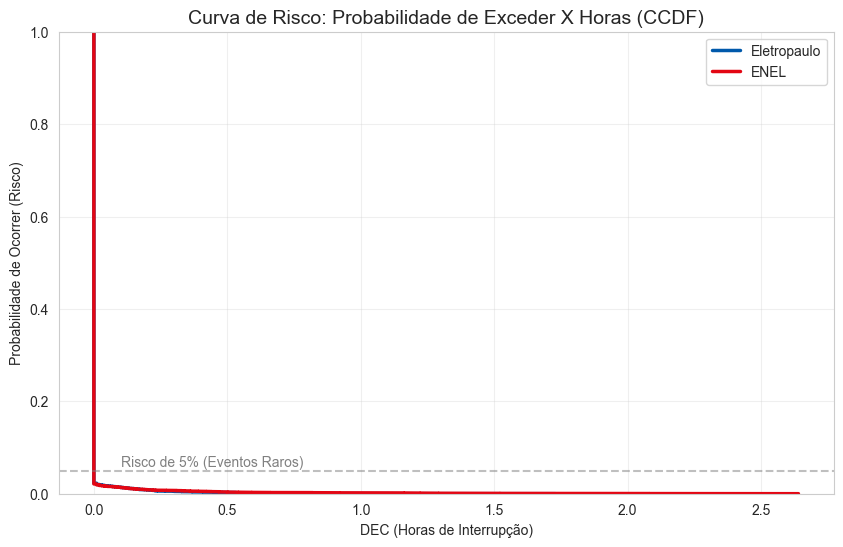

In [31]:
plt.figure(figsize=(10, 6))

# stat='proportion' mostra probabilidade (0 a 1)
# complementary=True inverte o gráfico (1 - CDF), focando no risco de cauda
sns.ecdfplot(dec_eletro, stat="proportion", complementary=True, color='#0059ab', label='Eletropaulo', linewidth=2.5)
sns.ecdfplot(dec_enel, stat="proportion", complementary=True, color='#e30613', label='ENEL', linewidth=2.5)

plt.title('Curva de Risco: Probabilidade de Exceder X Horas (CCDF)', fontsize=14)
plt.xlabel('DEC (Horas de Interrupção)')
plt.ylabel('Probabilidade de Ocorrer (Risco)')
plt.axhline(0.05, color='gray', linestyle='--', alpha=0.5) # Linha de 5% de risco
plt.text(0.1, 0.06, 'Risco de 5% (Eventos Raros)', color='gray')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

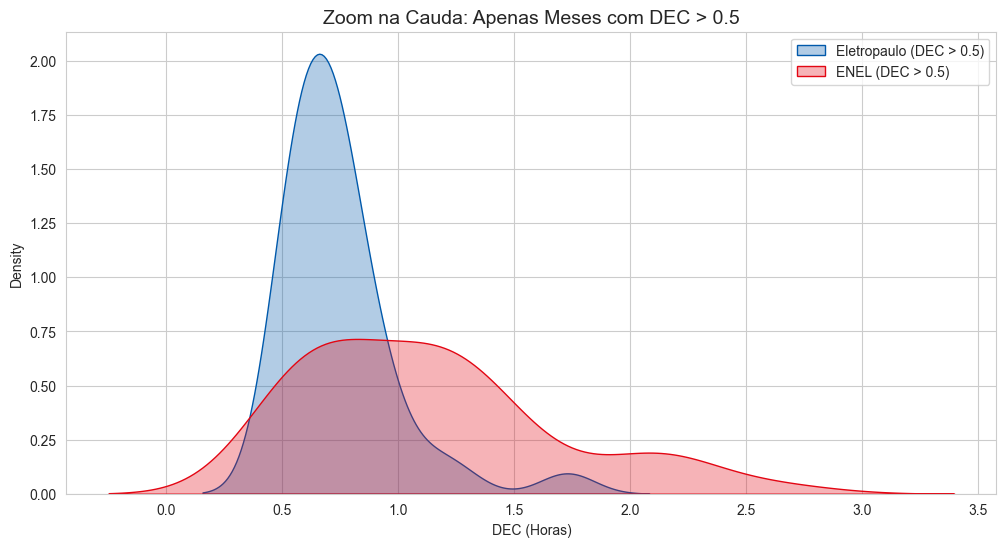

In [32]:
plt.figure(figsize=(12, 6))

# Filtrando apenas o caos
limite_inferior = 0.5
dados_cauda_eletro = dec_eletro[dec_eletro > limite_inferior]
dados_cauda_enel = dec_enel[dec_enel > limite_inferior]

sns.kdeplot(dados_cauda_eletro, fill=True, color='#0059ab', label=f'Eletropaulo (DEC > {limite_inferior})', alpha=0.3)
sns.kdeplot(dados_cauda_enel, fill=True, color='#e30613', label=f'ENEL (DEC > {limite_inferior})', alpha=0.3)

plt.title(f'Zoom na Cauda: Apenas Meses com DEC > {limite_inferior}', fontsize=14)
plt.xlabel('DEC (Horas)')
plt.legend()
plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_18072\3449242727.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


c:\Users\julia\OneDrive\Documentos\Dados\ENEL\.venv\Lib\site-packages\matplotlib\transforms.py:352: RuntimeWarning:

invalid value encountered in scalar subtract



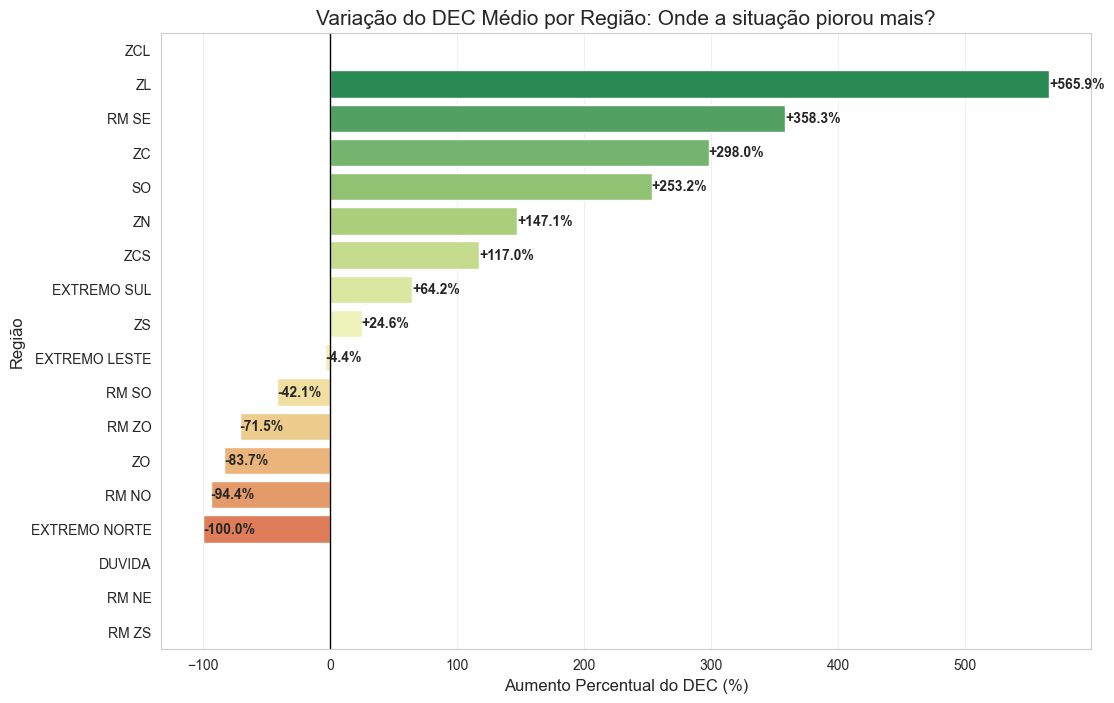

In [33]:
# 1. Garantir que temos a coluna 'REGIAO' no DataFrame principal
# Se você já rodou o mapeamento antes, pule esta linha.
# Caso contrário, certifique-se de que a coluna de conjuntos está limpa (sem acentos)
# Dica: Use a função de limpeza que discutimos se necessário

# 3. Calculando a Média do DEC por Região e Distribuidora
resumo_regiao = dec_ext_np.groupby(['Regiao', 'Distribuidora'])['DEC'].mean().reset_index()

# 4. Pivotar para formato de comparação (Colunas: Eletropaulo, ENEL)
tabela_comparativa = resumo_regiao.pivot(index='Regiao', columns='Distribuidora', values='DEC')

# 5. Calcular a Variação Percentual (%)
tabela_comparativa['Variação %'] = ((tabela_comparativa['ENEL'] - tabela_comparativa['Eletropaulo']) / tabela_comparativa['Eletropaulo']) * 100

# Ordenar do pior aumento para o menor
tabela_comparativa = tabela_comparativa.sort_values('Variação %', ascending=False)

# 6. Visualizando os Culpados
plt.figure(figsize=(12, 8))

# Criando um gráfico de barras horizontal
sns.barplot(x=tabela_comparativa['Variação %'], y=tabela_comparativa.index, palette='RdYlGn_r')

plt.axvline(0, color='black', linewidth=1) # Linha do zero
plt.title('Variação do DEC Médio por Região: Onde a situação piorou mais?', fontsize=15)
plt.xlabel('Aumento Percentual do DEC (%)', fontsize=12)
plt.ylabel('Região', fontsize=12)

# Adicionar rótulos nas barras
for index, value in enumerate(tabela_comparativa['Variação %']):
    plt.text(value, index, f'{value:+.1f}%', va='center', fontsize=10, fontweight='bold')

plt.grid(axis='x', alpha=0.3)
plt.show()